# Optimize Neural Network to minimize Monte Carlo error

The goal of this notebook is to expore if it is possible to optimize a neural network taking as loss function a the integration error coming from the Transformer Monte Carlo that uses the neural network as transformation.

We will consider the integral
$$
\int dx \, \frac{e^{-x^2}}{\sqrt{\pi}} \cos(20 \, x)
$$

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime

### Optmize neural network

In [3]:
rho = tfp.distributions.Normal(loc=0., scale=1.)

def g(x):
    return tf.cos(20. * x)

We sample directly from normal distribution, without building a Markov Chain. In this way auto-correlations are avoided altogether.

In [4]:
Nmc = 100000
x = rho.sample(Nmc)
g_values = g(x)

In [5]:
def print_mc_integral(estimates):
    print(f'Integral = { np.mean(estimates)} +- { np.std(estimates)/np.sqrt(len(estimates)) }')

We define a function that generates a neural network $n: \mathbb{R} \mapsto \mathbb{R}$, with a single hidden layer of size `size` with a non-linear activation function.

In [6]:
def get_nn(size=15):
    return tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=size, input_shape=(1,), activation=tf.keras.activations.tanh),
        tf.keras.layers.Dense(units=1, activation=tf.keras.activations.tanh),
        tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear)])

We also introduce a function that plots the neural network in a `xy` graph.

In [7]:
def plot_nn_transformation(nn):
    span = np.arange(-6., 6., 0.1)
    plt.scatter(x=span, y=(nn.predict([x for x in span])), label=r'$n(x)$')
    plt.plot(span, span, label=r'$x$')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$n(x)$')
    plt.show()

Let us plot a neural netowrk as an example.

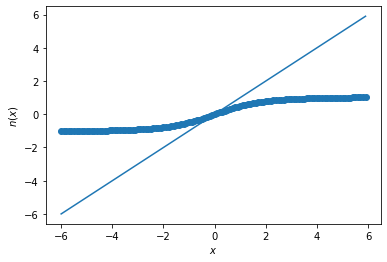

In [11]:
plot_nn_transformation(get_nn())

Following what we have found out in the notebook 1 in this folder, we define two functions.

`compute_g_t_estimates` computes $g_t(x)$, given a transformation defined by a tensorflow neural network. Notice that the function is restricted to the 1-dimensional case, as it does not contain the determinant of a jacobian matrix.

`transformer_mc_loss` returns the standard deviation of the integral computed using $\frac{g(x) + g_t(x)}{2}$, which will be the loss of our optimization algorithm (it is equivalent to the integration error, except for an irrelevant `Nmc` scale factor).

In [12]:
def compute_g_t_estimates(x, nn, rho):
    x_nn = tf.reshape(x, (len(x), 1))
    
    with tf.GradientTape() as tape_dx:
        tape_dx.watch(x_nn)
        t = nn(x_nn)
    dn_dx = tape_dx.gradient(t, x_nn)
        
    rho_factors = rho(t) / rho(x_nn)
    
    g_of_t = g(t)
                    
    return tf.reshape(rho_factors * dn_dx * g_of_t, (len(x)))


def transformer_mc_loss(x, g_values, nn, rho):
    x_nn = tf.reshape(x, (len(x), 1))
    
    with tf.GradientTape() as tape_dx:
        tape_dx.watch(x_nn)
        t = nn(x_nn)
    dn_dx = tape_dx.gradient(t, x_nn)
        
    rho_factors = rho(t) / rho(x_nn)
    
    g_of_t = g(t)
        
    g_n_estimates = rho_factors * dn_dx * g_of_t
        
    transformer_mc_estimates = 0.5 * (tf.reshape(g_n_estimates, (len(x))) + g_values)
    
    return tf.nn.moments(transformer_mc_estimates, axes=[0])[1]

Introduce a class to optimize multiple neural networks to minimize the loss defined above. It accepts multiple neural networks in the initialization, and during the optimization (`fit` method) it optimize them, and allows to choose the best ones to keep (the ones with the lowest loss).

We will use this class few cells below this one.

In [13]:
class TransformerMonteCarloModel:
    
    def __init__(self, rho, g, nns, loss_fn, optimizer):
        self.rho = rho
        self.g = g
        self.nns = nns
        self.loss_fn = loss_fn
        self.optimizer = optimizer
      
    def _compute_loss(self, x, g_values, nn):
        return self.loss_fn(x, g_values, nn, self.rho)
        
    def _get_nn_variables(self, nn):
        return [v for l in nn.layers for v in l.variables]
      
    def _get_loss_and_gradient(self, x, g_values, nn, rho):
        nn_parameters = self._get_nn_variables(nn)
        with tf.GradientTape() as tape:
            tape.watch(nn_parameters)
            loss = self._compute_loss(x, g_values, nn)
        gradient = tape.gradient(loss, nn_parameters)
                        
        return loss, gradient
    
    def _keep_best_nns(self, n_to_keep, x, g_values):
        if n_to_keep is not None:
            nn_losses = [self._compute_loss(x, g_values, nn) for nn in self.nns]
            sorted_nn_losses_and_nns = sorted(zip(nn_losses, self.nns), key=lambda x: x[0].numpy())
            self.nns = [nn for loss, nn in sorted_nn_losses_and_nns[0:n_to_keep]]
      
    def fit(self, x, g_values, batch_size=32, epochs=[1, 1], epoch_nns=[None, 1], shuffle=True):
        x_dataset = tf.data.Dataset.from_tensor_slices(x)
        g_values_dataset = tf.data.Dataset.from_tensor_slices(g_values)
        dataset = tf.data.Dataset.zip((x_dataset, g_values_dataset))
            
        for n_epochs, n_nns in zip(epochs, epoch_nns):
            nn_losses = [self._fit_single_nn(nn, self.rho, dataset, batch_size, n_epochs, shuffle) 
                         for nn in self.nns]
            
            self._keep_best_nns(n_nns, x, g_values)
                
            print(f'{ n_epochs } epochs of { epochs } '
                  f'--- Number of nns = {len(self.nns)} '
                  f'--- Losses = {[self._compute_loss(x, g_values, nn).numpy() for nn in self.nns]}')
            print()
            
    def _fit_single_nn(self, nn, rho, dataset, batch_size, epochs, shuffle=True):
        for epoch in range(epochs): 
            if shuffle:
                dataset.shuffle(len(dataset))
                
            for x_batch, g_values_batch in dataset.batch(batch_size, drop_remainder=True).as_numpy_iterator():
                loss, gradient = self._get_loss_and_gradient(x_batch, g_values_batch, nn, rho)
                self.optimizer.apply_gradients(zip(gradient, self._get_nn_variables(nn)))
        return loss.numpy()

We first show the value of the Monte Carlo integral using the direct approach (sampled points and corresponding estimates):

In [14]:
print_mc_integral(g_values)

Integral = -0.00031447468791157007 +- 0.002234938151530043


We then show the integral using the analytical transformation $x \mapsto x + \frac{\pi}{20}$:

In [15]:
print_mc_integral(0.5 * (g_values + compute_g_t_estimates(x, lambda x: x + math.pi/20., rho.prob)))

Integral = -3.109475801466033e-05 +- 0.0001765909751378701


The Monte Carlo error is sensibly reduced.

Now we try to see what we can do by optimizing a neural network. For this purpose we will use the class `TransformerMonteCarloModel`. We will experiment with 100 neural networks of size 15, and we will optimize them for 2 epochs, then keep only the best 25, then optimize them for further 5 epochs and keep the best 10 models, then 20 epochs - 5 models, 50 epochs - 2 models, and finally 100 epochs - 1 model.

2 epochs of [2, 5, 20, 50, 100] --- Number of nns = 25 --- Losses = [0.09744144, 0.10785416, 0.10930291, 0.11285857, 0.118161686, 0.11918221, 0.11988226, 0.12006705, 0.12258418, 0.122678556, 0.1238402, 0.124006756, 0.12487283, 0.12487435, 0.124875136, 0.12488064, 0.12488243, 0.12492994, 0.12495512, 0.124990605, 0.12512611, 0.12534371, 0.12543604, 0.12553059, 0.12555295]

5 epochs of [2, 5, 20, 50, 100] --- Number of nns = 10 --- Losses = [0.09215406, 0.09255954, 0.09939136, 0.10116867, 0.10459143, 0.10558208, 0.10654633, 0.10659662, 0.10733115, 0.108354434]

20 epochs of [2, 5, 20, 50, 100] --- Number of nns = 5 --- Losses = [0.08994381, 0.09008908, 0.090828456, 0.09124262, 0.09306821]

50 epochs of [2, 5, 20, 50, 100] --- Number of nns = 2 --- Losses = [0.06411803, 0.064807214]

100 epochs of [2, 5, 20, 50, 100] --- Number of nns = 1 --- Losses = [0.05414222]

Integral = 0.003195378929376602 +- 0.0007358139638404676


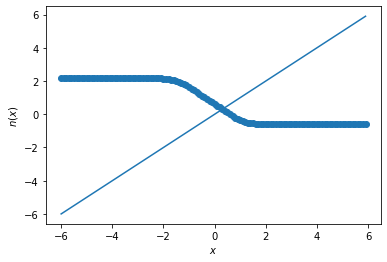

In [16]:
model1 = TransformerMonteCarloModel(rho=rho.prob, g=g, nns=[get_nn() for i in range(100)], 
                                   loss_fn=transformer_mc_loss,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.025))
model1.fit(x=x, g_values=g_values, batch_size=10000, epochs=[2, 5, 20, 50, 100], epoch_nns=[25, 10, 5, 2, 1])

print_mc_integral(0.5 * (g_values + compute_g_t_estimates(x, model1.nns[0], rho.prob)))

plot_nn_transformation(model1.nns[0])

The integral shows that we have reduced the Monte Carlo error compared to the direct integration. However, the gain is not comparable to what we have obtained with the analytical transformation.

The plot shows the optimized neural network transformation. It is very different from the analytical one, even though it shares the linear nature in the region of high sampling probability.

We repeat our experiment, this time starting with 15 models, and optimizing them for more epochs before reducing their number.

30 epochs of [30, 50, 100] --- Number of nns = 5 --- Losses = [0.075092025, 0.08265713, 0.092833035, 0.09738459, 0.09797645]

50 epochs of [30, 50, 100] --- Number of nns = 2 --- Losses = [0.06780797, 0.0732318]

100 epochs of [30, 50, 100] --- Number of nns = 1 --- Losses = [0.06085974]

Integral = -0.0006586355739273131 +- 0.0007801265125078502


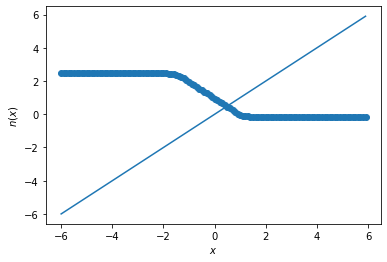

In [17]:
model2 = TransformerMonteCarloModel(rho=rho.prob, g=g, nns=[get_nn() for i in range(15)], 
                                   loss_fn=transformer_mc_loss,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.025))
model2.fit(x=x, g_values=g_values, batch_size=10000, epochs=[30, 50, 100], epoch_nns=[5, 2, 1])

print_mc_integral(0.5 * (g_values + compute_g_t_estimates(x, model2.nns[0], rho.prob)))

plot_nn_transformation(model2.nns[0])

The result is very similar to what we have obtained before, showing that taking less models and optimizing them for more epochs does not lead to significant differences.

### Measure Monte Carlo efficiency

Given that we are able to reduce the Monte Carlo error, we now want to question if such reduction can justify the increased computational time.

We introduce a function that, given a neural network as transformation, computes the Monte Carlo error and used cpu time with and without the use of the transformation for several values of $N_{\text{MC}}$.
Notice that to avoid fluctuations, we measure the cpu time 4 times and keep the lowest value.

We point out that in these measurements we do not consider the time necessary to optimize the neural network, even though this is a heavy computational task.

In [18]:
def compute_evaluations(nn):
    Nmcs = list()
    mc_errors = list()
    tmc_errors = list()
    mc_cpu_times = list()
    tmc_cpu_times = list()
    for n in np.arange(10000, 1000000, 100000):
        best_t1_t0 = None
        for i in range(4):
            t0 = datetime.now()
            large_x = rho.sample(n)
            t1 = datetime.now()
            t1_t0 = t1-t0
            best_t1_t0 = t1_t0 if best_t1_t0 is None else min(best_t1_t0, t1_t0)
        Nmcs.append(n)

        best_t3_t2 = None
        for i in range(4):
            t2 = datetime.now()
            large_g_values = g(large_x)
            t3 = datetime.now()
            t3_t2 = t3-t2
            best_t3_t2 = t3_t2 if best_t3_t2 is None else min(best_t3_t2, t3_t2)
        mc_std_err = np.std(large_g_values)/np.sqrt(len(large_g_values))
        mc_errors.append(mc_std_err)
        mc_cpu_times.append((best_t1_t0+best_t3_t2).microseconds)

        best_t5_t4 = None
        for i in range(4):
            t4 = datetime.now()
            large_gt_values = 0.5 * (large_g_values + compute_g_t_estimates(large_x, nn, rho.prob))
            t5 = datetime.now()
            t5_t4 = t5-t4
            best_t5_t4 = t5_t4 if best_t5_t4 is None else min(best_t5_t4, t5_t4)
        tmc_std_err = np.std(large_gt_values)/np.sqrt(len(large_gt_values))
        tmc_errors.append(tmc_std_err)
        tmc_cpu_times.append((best_t1_t0+best_t3_t2+best_t5_t4).microseconds)
    return Nmcs, mc_errors, tmc_errors, mc_cpu_times, tmc_cpu_times

In [19]:
def plot_evaluations(Nmcs, mc_errors, tmc_errors, mc_cpu_times, tmc_cpu_times):
    plt.figure(figsize=(6, 4))
    plt.scatter(x=Nmcs, y=mc_errors, label='Monte Carlo')
    plt.plot(Nmcs, mc_errors)
    plt.scatter(x=Nmcs, y=tmc_errors, label='Transformer Monte Carlo')
    plt.plot(Nmcs, tmc_errors)
    plt.xlabel('Number of samplings')
    plt.ylabel('Integral estimation error')
    plt.legend()
    plt.semilogy()
    plt.semilogx()
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.scatter(x=Nmcs, y=1./(np.array(mc_cpu_times)*np.array(mc_errors)*np.array(mc_errors)), label='Monte Carlo')
    plt.scatter(x=Nmcs, y=1./(np.array(tmc_cpu_times)*np.array(tmc_errors)*np.array(mc_errors)), label='Transformer Monte Carlo')
    plt.xlabel('Number of samplings')
    plt.ylabel('Monte Carlo Efficiency')
    plt.legend()
    plt.show()

In [20]:
Nmcs, mc_errors, tmc_errors, mc_cpu_times, tmc_cpu_times = compute_evaluations(model1.nns[0])

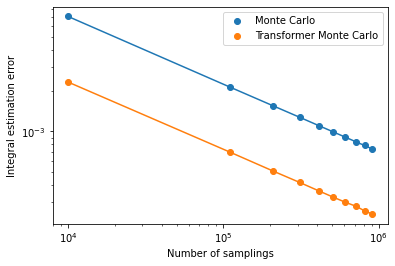

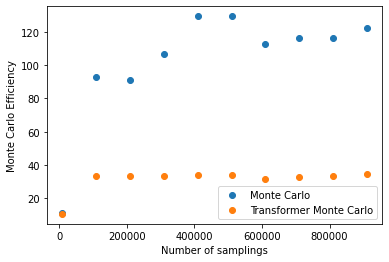

In [21]:
plot_evaluations(Nmcs, mc_errors, tmc_errors, mc_cpu_times, tmc_cpu_times)

Monte Carlo efficiency is defined as:
$$
\eta = \frac{N_{\text{MC}} - 1}{\text{cpu time} \times \text{var}}
$$
where $\text{var}$ is the variance of the estimation.

The result clearly shows that using the Transformer Monte Carlo with an optimized neural network is **less efficient** in this particular case.

We try to repeat the experiment reducing the size of the neural network to 3.

2 epochs of [2, 5, 20, 50, 100] --- Number of nns = 25 --- Losses = [0.10035295, 0.100592166, 0.102326386, 0.10625215, 0.10636536, 0.10871413, 0.11079808, 0.11090818, 0.11135947, 0.11282093, 0.1139734, 0.11483783, 0.124447696, 0.12487353, 0.12487417, 0.12487582, 0.12487588, 0.12487662, 0.12487743, 0.12487834, 0.124884784, 0.12488761, 0.12488949, 0.124890916, 0.12489459]

5 epochs of [2, 5, 20, 50, 100] --- Number of nns = 10 --- Losses = [0.0921592, 0.09383123, 0.09430053, 0.094721474, 0.09497988, 0.095154904, 0.095706135, 0.096027404, 0.097044066, 0.0972533]

20 epochs of [2, 5, 20, 50, 100] --- Number of nns = 5 --- Losses = [0.041445922, 0.056742508, 0.058956593, 0.06585797, 0.06746016]

50 epochs of [2, 5, 20, 50, 100] --- Number of nns = 2 --- Losses = [0.020875162, 0.03229946]

100 epochs of [2, 5, 20, 50, 100] --- Number of nns = 1 --- Losses = [0.012638258]

Integral = 0.0002552578807808459 +- 0.00035550325498587824


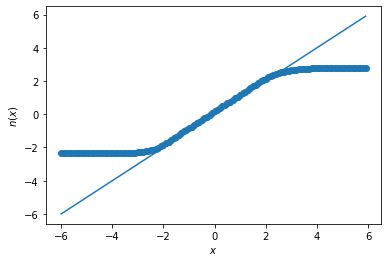

In [22]:
model3 = TransformerMonteCarloModel(rho=rho.prob, g=g, nns=[get_nn(size=3) for i in range(100)], 
                                   loss_fn=transformer_mc_loss,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.025))
model3.fit(x=x, g_values=g_values, batch_size=10000, epochs=[2, 5, 20, 50, 100], epoch_nns=[25, 10, 5, 2, 1])

print_mc_integral(0.5 * (g_values + compute_g_t_estimates(x, model3.nns[0], rho.prob)))

plot_nn_transformation(model3.nns[0])

In [23]:
Nmcs, mc_errors, tmc_errors, mc_cpu_times, tmc_cpu_times = compute_evaluations(model3.nns[0])

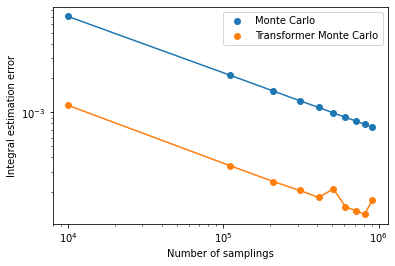

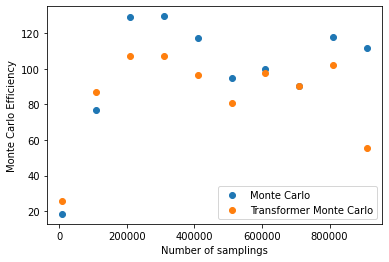

In [24]:
plot_evaluations(Nmcs, mc_errors, tmc_errors, mc_cpu_times, tmc_cpu_times)

Also in this case the Transformer Monte Carlo is slightly less efficient than the original.

In the following we tries with size 2, 1, and 5, obtaining similar results.

2 epochs of [2, 5, 20, 50, 100] --- Number of nns = 25 --- Losses = [0.09365213, 0.10220756, 0.10681897, 0.10773962, 0.11791725, 0.1233733, 0.12443809, 0.124872275, 0.12487265, 0.12487288, 0.124873, 0.1248737, 0.12487379, 0.124873884, 0.12487393, 0.12487415, 0.1248744, 0.124875724, 0.12487576, 0.124875896, 0.124876775, 0.12487855, 0.12488133, 0.12488278, 0.1248841]

5 epochs of [2, 5, 20, 50, 100] --- Number of nns = 10 --- Losses = [0.08941836, 0.09017707, 0.09352799, 0.096374005, 0.09770293, 0.097786814, 0.09793226, 0.12487283, 0.12487287, 0.12487337]

20 epochs of [2, 5, 20, 50, 100] --- Number of nns = 5 --- Losses = [0.07491007, 0.088884845, 0.08938844, 0.090313986, 0.090322755]

50 epochs of [2, 5, 20, 50, 100] --- Number of nns = 2 --- Losses = [0.048108257, 0.086852595]

100 epochs of [2, 5, 20, 50, 100] --- Number of nns = 1 --- Losses = [0.039321017]

Integral = 0.002851257100701332 +- 0.0006270646880059672


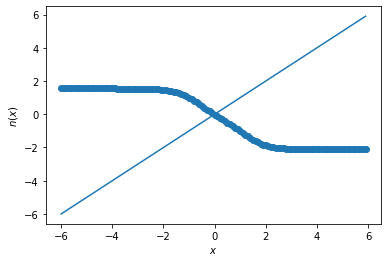

In [25]:
model4 = TransformerMonteCarloModel(rho=rho.prob, g=g, nns=[get_nn(size=2) for i in range(100)], 
                                   loss_fn=transformer_mc_loss,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.025))
model4.fit(x=x, g_values=g_values, batch_size=10000, epochs=[2, 5, 20, 50, 100], epoch_nns=[25, 10, 5, 2, 1])

print_mc_integral(0.5 * (g_values + compute_g_t_estimates(x, model4.nns[0], rho.prob)))

plot_nn_transformation(model4.nns[0])

In [26]:
Nmcs, mc_errors, tmc_errors, mc_cpu_times, tmc_cpu_times = compute_evaluations(model4.nns[0])

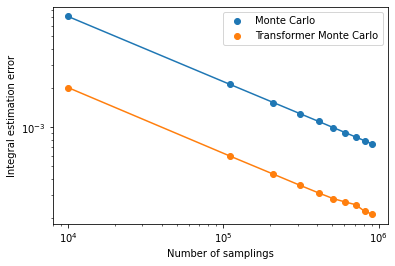

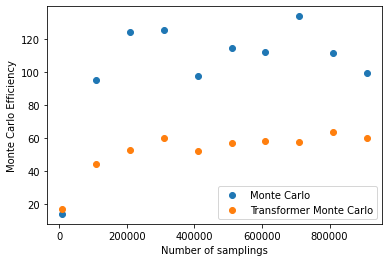

In [27]:
plot_evaluations(Nmcs, mc_errors, tmc_errors, mc_cpu_times, tmc_cpu_times)

2 epochs of [2, 5, 20, 50, 100] --- Number of nns = 25 --- Losses = [0.09510754, 0.09896319, 0.10311141, 0.10740528, 0.12487223, 0.12487242, 0.12487243, 0.12487247, 0.12487274, 0.12487312, 0.124873206, 0.1248733, 0.12487344, 0.124873556, 0.124873646, 0.12487368, 0.1248737, 0.12487376, 0.12487379, 0.12487394, 0.12487394, 0.124873996, 0.12487414, 0.12487416, 0.124874294]

5 epochs of [2, 5, 20, 50, 100] --- Number of nns = 10 --- Losses = [0.09347173, 0.09386793, 0.09528236, 0.098528855, 0.12487161, 0.124871634, 0.12487223, 0.12487242, 0.124872595, 0.12487293]

20 epochs of [2, 5, 20, 50, 100] --- Number of nns = 5 --- Losses = [0.09029006, 0.09073549, 0.09086044, 0.09130906, 0.12487146]

50 epochs of [2, 5, 20, 50, 100] --- Number of nns = 2 --- Losses = [0.08852979, 0.090079725]

100 epochs of [2, 5, 20, 50, 100] --- Number of nns = 1 --- Losses = [0.08810842]

Integral = -0.003822492901235819 +- 0.000938660757967209


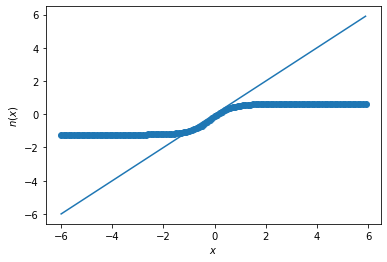

In [28]:
model5 = TransformerMonteCarloModel(rho=rho.prob, g=g, nns=[get_nn(size=1) for i in range(100)], 
                                   loss_fn=transformer_mc_loss,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.025))
model5.fit(x=x, g_values=g_values, batch_size=10000, epochs=[2, 5, 20, 50, 100], epoch_nns=[25, 10, 5, 2, 1])

print_mc_integral(0.5 * (g_values + compute_g_t_estimates(x, model5.nns[0], rho.prob)))

plot_nn_transformation(model5.nns[0])

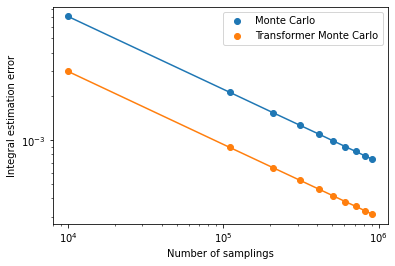

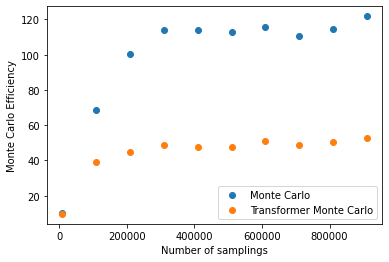

In [29]:
plot_evaluations(*compute_evaluations(model5.nns[0]))

2 epochs of [2, 5, 20, 50, 100] --- Number of nns = 25 --- Losses = [0.09236754, 0.09989343, 0.101598926, 0.102174856, 0.10280555, 0.10373556, 0.10656906, 0.1099302, 0.11550328, 0.1189984, 0.11933199, 0.1202309, 0.123228535, 0.123885594, 0.12487326, 0.124873675, 0.12488122, 0.12488414, 0.1248867, 0.124931015, 0.124960996, 0.12497527, 0.12498789, 0.12499746, 0.12509361]

5 epochs of [2, 5, 20, 50, 100] --- Number of nns = 10 --- Losses = [0.09216105, 0.09296207, 0.09435306, 0.094515204, 0.09563077, 0.09586696, 0.09812666, 0.09845857, 0.098459296, 0.0986667]

20 epochs of [2, 5, 20, 50, 100] --- Number of nns = 5 --- Losses = [0.060603626, 0.060735825, 0.06621336, 0.06843712, 0.08948041]

50 epochs of [2, 5, 20, 50, 100] --- Number of nns = 2 --- Losses = [0.024116172, 0.046716075]

100 epochs of [2, 5, 20, 50, 100] --- Number of nns = 1 --- Losses = [0.016440101]

Integral = 0.0013225889997556806 +- 0.00040546396465207605


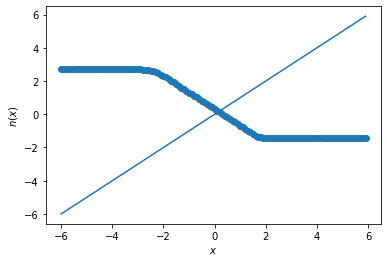

In [30]:
model6 = TransformerMonteCarloModel(rho=rho.prob, g=g, nns=[get_nn(size=5) for i in range(100)], 
                                   loss_fn=transformer_mc_loss,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.025))
model6.fit(x=x, g_values=g_values, batch_size=10000, epochs=[2, 5, 20, 50, 100], epoch_nns=[25, 10, 5, 2, 1])

print_mc_integral(0.5 * (g_values + compute_g_t_estimates(x, model6.nns[0], rho.prob)))

plot_nn_transformation(model6.nns[0])

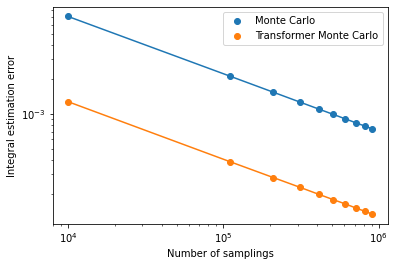

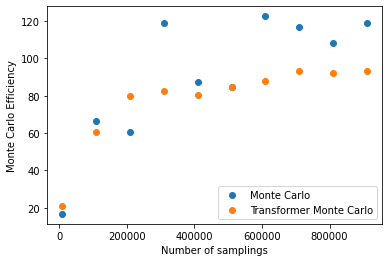

In [31]:
plot_evaluations(*compute_evaluations(model6.nns[0]))

### Conclusion

* It is possible to optimize a neural network to minimize the Monte Carlo error, using the Transformer Monte Carlo approach

* From our first simple approach, it seems that the computational overhead due to the computation of the neural network transformation is not justified by the reduction in Monte Carlo error. This may be reduced by technically optimizing the performance of the code, by better optimizing the neural network, or by going beyond the case of a single transformation with equal weights $\alpha_0 = \alpha_1 = \frac{1}{2}$